In [1]:
from scipy import stats
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator, FormatStrFormatter, PercentFormatter
import seaborn as sns

from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, RobustScaler, PowerTransformer, OneHotEncoder
le = LabelEncoder()
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.metrics import accuracy_score, log_loss, confusion_matrix, roc_curve, precision_recall_curve
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.feature_selection import RFECV
from sklearn.datasets import make_classification

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras import backend as K
from tensorflow.keras.models import load_model


# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)

# Hyperparameters

In [2]:
# -----------------------------------------------------------------
# Some parameters to config 
PRODUCTION = False

# Hyperparameters
FOLDS = 5 if PRODUCTION else 5   # Only 5 or 10.
EPOCHS = 161        # Does not matter with Early stopping. Deep network should not take too much epochs to learn
BATCH_SIZE = 2048   # large enough to fit RAM. If unstable, tuned downward. 4096 2048
ACTIVATION = 'selu' # swish mish relu selu ;swish seem to work better with binary classification only?
KERNEL_INIT = "lecun_normal" # Minimal impact, but give your init the right foot forward glorot_uniform
LEARNING_RATE = 0.000965713 # Not used. Optimal lr is about half the maximum lr 
LR_FACTOR = 0.7   # LEARNING_RATE * LR_FACTOR = New Learning rate on ReduceLROnPlateau. lower down when the LR oscillate
MIN_DELTA = 0.0000001 # Default 0.0001 0.0000001
RLRP_PATIENCE = 7 # Learning Rate reduction on ReduceLROnPlateau
ES_PATIENCE = 27  # Early stopping
DROPOUT = 0.15     # Act like L1 L2 regulator. lower your learning rate in order to overcome the "boost" that the dropout probability gives to the learning rate.
HIDDEN_LAYERS = [128, 256, 128, 64]

OPTIMIZER = 'adam' # adam adamax nadam
LOSS ='sparse_categorical_crossentropy' # sparse_categorical_crossentropy does not require onehot encoding on labels. categorical_crossentropy
METRICS ='accuracy'  # acc accuracy categorical_accuracy sparse_categorical_accuracy
ACC_VAL_METRICS = 'val_accuracy' # 'val_acc' val_accuracy val_sparse_categorical_accuracy
ACC_METRICS = 'accuracy' # acc accuracy 'sparse_categorical_accuracy'

# The dataset is too huge for trial. Sampling it for speed run!
SAMPLE = 2262087 if PRODUCTION else 31426   # True for FULL run. Max Sample size per category. For quick test: y counts [1468136, 2262087, 195712, 377, 1, 11426, 62261]  # 4000000 total rows
VALIDATION_SPLIT = 0.15 # Only used to min dataset for quick test
MAX_TRIAL = 3           # speed trial any% Not used here
MI_THRESHOLD = 0.001    # Mutual Information threshold value to drop.

RANDOM_STATE = 42
VERBOSE = 0

# Admin
ID = "Id"            # Id id x X index
INPUT = "../input/tabular-playground-series-dec-2021"
TPU = False           # True: use TPU.
BEST_OR_FOLD = False # True: use Best model, False: use KFOLD softvote
FEATURE_ENGINEERING = True
PSEUDO_LABEL = True

assert BATCH_SIZE % 2 == 0, \
    "BATCH_SIZE must be even number."

# Misc functions

In [3]:
def plot_acc(history_f):
    fold = 0
    best_epoch = np.argmin(np.array(history_f['val_loss']))
    best_val_loss = history_f['val_loss'][best_epoch]

    fig, ax1 = plt.subplots(1, 2, tight_layout=True, figsize=(15,4))

    fig.suptitle('Fold : '+ str(fold+1) +
                 " Validation Loss: {:0.4f}".format(history_f['val_loss'].min()) +
                 " Validation Accuracy: {:0.4f}".format(history_f[ACC_VAL_METRICS].max()) +
                 " LR: {:0.8f}".format(history_f['lr'].min())
                 , fontsize=14)

    plt.subplot(1,2,1)
    plt.plot(history_f.loc[:, ['loss', 'val_loss']], label= ['loss', 'val_loss'])

    from_epoch = 0
    if best_epoch >= from_epoch:
        plt.scatter([best_epoch], [best_val_loss], c = 'r', label = f'Best val_loss = {best_val_loss:.5f}')
    if best_epoch > 0:
        almost_epoch = np.argmin(np.array(history_f['val_loss'])[:best_epoch])
        almost_val_loss = history_f['val_loss'][almost_epoch]
        if almost_epoch >= from_epoch:
            plt.scatter([almost_epoch], [almost_val_loss], c='orange', label = 'Second best val_loss')
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper left')   

    ax2 = plt.gca().twinx()
    ax2.plot(history_f.loc[:, ['lr']], 'y:', label='lr' ) # default color is same as first ax
    ax2.set_ylabel('Learning rate')
    ax2.legend(loc = 'upper right')
    ax2.grid()

    best_epoch = np.argmax(np.array(history_f[ACC_VAL_METRICS]))
    best_val_acc = history_f[ACC_VAL_METRICS][best_epoch]

    plt.subplot(1,2,2)
    plt.plot(history_f.loc[:, [ACC_METRICS, ACC_VAL_METRICS]],label= [ACC_METRICS, ACC_VAL_METRICS])
    if best_epoch >= from_epoch:
        plt.scatter([best_epoch], [best_val_acc], c = 'r', label = f'Best val_acc = {best_val_acc:.5f}')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc = 'lower left')
    plt.legend(fontsize = 15)
    plt.grid(b = True, linestyle = '-')


# Load dataset

In [4]:
# load the dataset
def load_dataset():
    return make_classification(
        n_samples=SAMPLE,
        n_features=9,
        n_informative=3,
        n_redundant=2,
        n_repeated=0,
        n_classes=6,
        n_clusters_per_class=1,
        weights= [0.25, 0.3, 0.1, 0.1, 0.1, 0.15],
        random_state=RANDOM_STATE,
    )

X, y = load_dataset()

In [61]:
X[:, 0].shape

(31426,)

# Plot

C:\Users\furyx\miniconda3\envs\tf27\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:title={'center':'Two informative features, one cluster per class'}>

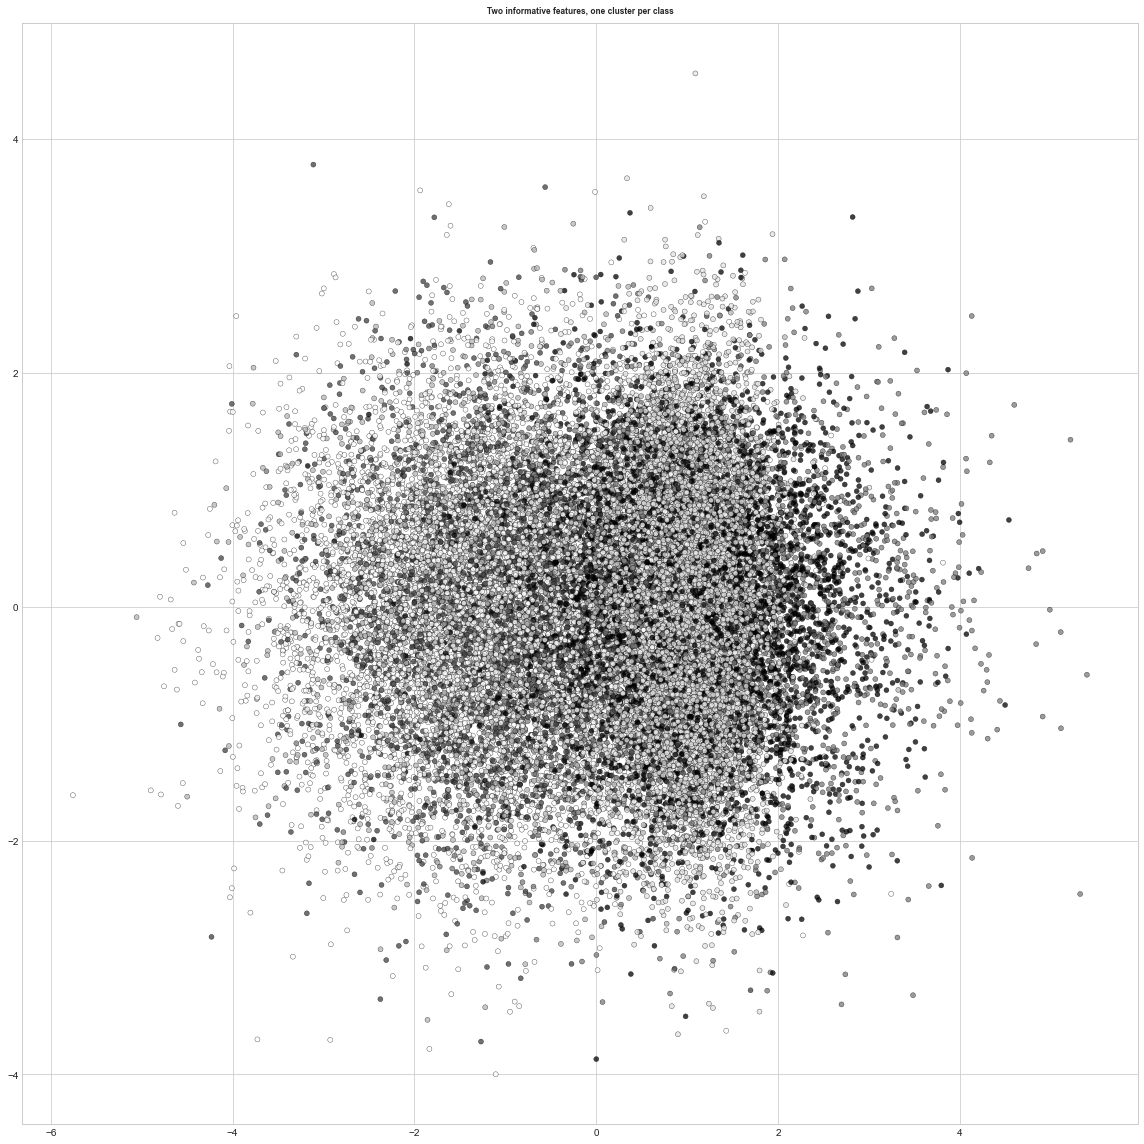

In [65]:
plt.figure(figsize=(16, 16))

plt.title("Two informative features, one cluster per class", fontsize="small")

sns.scatterplot(X[:, 0], X[:, 1], marker="o", c=y, s=25, edgecolor="k", alpha=0.75, palette="deep")

# Transform

In [6]:
# Prepare for multiclass classification tf.keras.utils.to_categorical(le.fit_transform(y[column_y])) categorical_crossentropy
y = le.fit_transform(y) # y to categorical

In [7]:
# train, val = train_test_split(X, test_size=VALIDATION_SPLIT, stratify=X[[TARGET_FEATURE_NAME]], random_state=RANDOM_STATE)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.25, random_state=RANDOM_STATE)

In [8]:
np.unique(y_train, return_counts=True)

(array([0, 1, 2, 3, 4, 5], dtype=int64),
 array([4705, 5674, 1908, 1882, 1876, 2810], dtype=int64))

# Features Configs

In [9]:
# TARGET_FEATURE_NAME = column_y
TARGET_FEATURE_LABELS = np.unique(y)
NUM_CLASSES = len(TARGET_FEATURE_LABELS)

INPUT_SHAPE = X.shape[-1]
OUTPUT_SHAPE = le.classes_.shape[-1]

In [10]:
print(INPUT_SHAPE)
print(OUTPUT_SHAPE)
print(np.unique(y, return_counts=True))

9
6
(array([0, 1, 2, 3, 4, 5], dtype=int64), array([7835, 9375, 3165, 3151, 3169, 4731], dtype=int64))


# Models

In [11]:
modelCheckpoint = None

if TPU:
    save_locally = tf.saved_model.SaveOptions(experimental_io_device='/job:localhost')
    modelCheckpoint = ModelCheckpoint(  'best_model', options = save_locally,
                                        monitor = ACC_VAL_METRICS,
                                        mode = 'max',
                                        save_best_only = True,
                                        verbose = VERBOSE,
                                        )
else:
    modelCheckpoint = ModelCheckpoint(
                                        'best_model',
                                        monitor = ACC_VAL_METRICS,
                                        mode = 'max',
                                        save_best_only = True,
                                        verbose = VERBOSE,
                                        )

early_stopping = EarlyStopping(
        patience = ES_PATIENCE,
        min_delta = MIN_DELTA,
        monitor = ACC_VAL_METRICS,
        mode = 'max',
        restore_best_weights = True,       
        baseline = None,
        verbose = VERBOSE,
    )
plateau = ReduceLROnPlateau(
        patience = RLRP_PATIENCE,
        factor = LR_FACTOR,
        min_lr = 1e-7,
        monitor = 'val_loss', 
        mode = 'min',
        verbose = VERBOSE,
    )

In [12]:
def get_MLPmodel(**kwargs):
# -----------------------------------------------------------------
# Model , kernel_initializer="lecun_normal"
    model = keras.Sequential([
#     layers.BatchNormalization(input_shape = [X.shape[-1]], name = 'input'),
    layers.Dense(units = 300, input_shape = [INPUT_SHAPE], name = 'input', kernel_initializer = KERNEL_INIT, activation = ACTIVATION),
#     layers.Dropout(rate = DROPOUT),
    layers.BatchNormalization(),
    layers.Dense(units = 200, kernel_initializer = KERNEL_INIT, activation = ACTIVATION),
#     layers.Dropout(rate = DROPOUT),
    layers.BatchNormalization(),
    layers.Dense(units = 100, kernel_initializer = KERNEL_INIT, activation = ACTIVATION),
#     layers.Dropout(rate = DROPOUT),
    layers.BatchNormalization(),
    layers.Dense(units = 50, kernel_initializer = KERNEL_INIT, activation = ACTIVATION),
#     layers.Dropout(rate = DROPOUT),
    layers.BatchNormalization(),
    layers.Dense(units = OUTPUT_SHAPE, activation = 'softmax', name='output'), #y_cat.shape[-1]
    ])

    return model

In [13]:
class MCDropout(keras.layers.AlphaDropout):
    '''Boost the performance of any trained dropout model without having to retrain it or even modify it at all.
        Provide a much better measure of the models uncertainty'''
    def call(self, inputs):
        return super().call(inputs, training=True)

class Standardization(layers.Layer):
    def adapt(self, data_sample):
        self.means_ = np.mean(data_sample, axis = 0, keepdims = True)
        self.stds_ = np.std(data_sample, axis = 0, keepdims = True)
    def call(self, inputs):
        return (inputs - self.means_) / (self.stds_ + keras.backend.epsilon())
    
# create custom dense-block
class DenseBlock(layers.Layer):
    def __init__(self, units, activation = ACTIVATION, dropout_rate = 0, l2 = 0, **kwargs):
        super(DenseBlock, self).__init__(**kwargs)
        self.dense = layers.Dense(
            units = units, 
#             activation = activation,
            kernel_initializer = KERNEL_INIT, 
#             kernel_regularizer=keras.regularizers.l2(l2)
        )
        self.batchn = layers.BatchNormalization()
        self.activation = layers.Activation(activation)
        if dropout_rate > 0:
            self.dropout = MCDropout(rate = dropout_rate) #MCDropout layers.Dropout
        else:
            self.dropout = None
    
    def call(self, inputs):
        x = self.dense(inputs)
        x = self.activation(x)
        x = self.batchn(x)
        
        if self.dropout is not None:
            x = self.dropout(x)
            
        return x

# create fully-connected NN
class MLP(keras.Model):
    def __init__(self, hidden_layers = HIDDEN_LAYERS, activation = ACTIVATION, dropout_rate = DROPOUT, l2 = 0, **kwargs):
        super(MLP, self).__init__(**kwargs)

        self.hidden_layers = [DenseBlock(units = units,
                                         activation = activation,
                                         dropout_rate = dropout_rate,
                                         l2 = l2
                                        )
                              for units in hidden_layers
                             ]
        self.softmax = layers.Dense(units = OUTPUT_SHAPE, activation = 'softmax', name='output')
        
    def call(self, inputs):
        x = inputs
        for dense_layer in self.hidden_layers:
            x = dense_layer(x)
        x = self.softmax(x)
        return x

In [14]:
def wide_deep_model(**kwargs):
    il = layers.Input(shape=(INPUT_SHAPE), name="input")
    x = layers.Dense(units=128, activation=ACTIVATION)(il)
    x1 = layers.BatchNormalization()(x)
    x = layers.Dense(units=64, activation=ACTIVATION)(x1)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(DROPOUT)(layers.Concatenate()([x, x1])) #AlphaDropout
    x = layers.Dense(units=64, activation=ACTIVATION)(x) 
    x = layers.BatchNormalization()(x)
    x = layers.Dense(units=64, activation=ACTIVATION)(x)
    x = layers.BatchNormalization()(x)
    output = layers.Dense(units=NUM_CLASSES, activation="softmax", name="output")(x)

    model = tf.keras.Model([il], output)
    return model

In [15]:
# create dense & cross model
class CrossNet(keras.Model):
    def __init__(self, hidden_layers = HIDDEN_LAYERS, activation = ACTIVATION, dropout_rate = DROPOUT, l2 = 0, **kwargs):
        super(CrossNet, self).__init__(**kwargs)

        for i, units in enumerate(hidden_layers, start=1):
            if i == 1: # Dropout before last layer only len(hidden_layers)
                self.dense_layers = [DenseBlock(units = units, activation = activation, dropout_rate = dropout_rate, l2 = l2)]
            else:
                self.dense_layers.append(DenseBlock(units = units, activation = activation, dropout_rate = 0, l2 = l2))
        
        self.dense = layers.Dense(units = INPUT_SHAPE)
        self.concat = layers.Concatenate()
        self.batchn = layers.BatchNormalization()
        self.softmax = layers.Dense(units = OUTPUT_SHAPE, activation = 'softmax', name='output')
        
    def call(self, inputs):
        
        dense, cross = inputs, inputs
        
        for dense_layer in self.dense_layers:
            # Deep net TODO only dropout at last layer
            dense = dense_layer(dense)
            # Parrallel Cross net
            cross_current = self.dense(cross)
            cross = inputs * cross_current + cross
            
        cross = self.batchn(cross)
        
        merged = self.concat([dense, cross])
        return self.softmax(merged)

In [16]:
def create_model_inputs():
    inputs = {}
    for feature_name in FEATURE_NAMES:
        if feature_name in NUMERIC_FEATURE_NAMES:
            inputs[feature_name] = layers.Input(
                name=feature_name, shape=(), dtype=tf.float32
            )
        else:
            inputs[feature_name] = layers.Input(
                name=feature_name, shape=(), dtype=tf.string
            )
    return inputs

In [17]:
def encode_inputs(inputs, use_embedding=False):
    encoded_features = []
    for col in range(inputs.shape[1]):
        encoded_feature = tf.expand_dims(inputs[:, col], -1)
        encoded_features.append(encoded_feature)

    all_features = layers.concatenate(encoded_features)
    return all_features

In [18]:
class GatedLinearUnit(layers.Layer):
    def __init__(self, units, **kwargs):
        super(GatedLinearUnit, self).__init__(**kwargs)
        self.linear = layers.Dense(units)
        self.sigmoid = layers.Dense(units, activation="sigmoid")

    def call(self, inputs):
        return self.linear(inputs) * self.sigmoid(inputs)


class GatedResidualNetwork(layers.Layer):
    def __init__(self, units, dropout_rate, **kwargs):
        super(GatedResidualNetwork, self).__init__(**kwargs)
        self.units = units
        self.elu_dense = layers.Dense(units, activation="elu")
        self.linear_dense = layers.Dense(units)
        self.dropout = layers.Dropout(dropout_rate)
        self.gated_linear_unit = GatedLinearUnit(units)
        self.layer_norm = layers.LayerNormalization()
        self.project = layers.Dense(units)

    def call(self, inputs):
        x = self.elu_dense(inputs)
        x = self.linear_dense(x)
        x = self.dropout(x)
        if inputs.shape[-1] != self.units:
            inputs = self.project(inputs)
        x = inputs + self.gated_linear_unit(x)
        x = self.layer_norm(x)
        return x


class VariableSelection(layers.Layer):
    def __init__(self, num_features, units, dropout_rate, **kwargs):
        super(VariableSelection, self).__init__(**kwargs)
        self.grns = list()
        for idx in range(num_features):
            grn = GatedResidualNetwork(units, dropout_rate)
            self.grns.append(grn)
        self.grn_concat = GatedResidualNetwork(units, dropout_rate)
        self.softmax = layers.Dense(units=num_features, activation="softmax")

    def call(self, inputs):
        v = layers.concatenate(inputs)
        v = self.grn_concat(v)
        v = tf.expand_dims(self.softmax(v), axis=-1)

        x = []
        for idx, input in enumerate(inputs):
            x.append(self.grns[idx](input))
        x = tf.stack(x, axis=1)

        outputs = tf.squeeze(tf.matmul(v, x, transpose_a=True), axis=1)
        return outputs


In [19]:
def encode_vsn_inputs(inputs, encoding_size):
    encoded_features = []
    for col in range(inputs.shape[1]):
        encoded_feature = tf.expand_dims(inputs[:, col], -1)
        encoded_feature = layers.Dense(units=encoding_size)(encoded_feature)
        encoded_features.append(encoded_feature)
    return encoded_features


def create_grn_and_vsn_model(encoding_size, dropout_rate=DROPOUT):
    inputs = layers.Input(len(X.columns))
    feature_list = encode_vsn_inputs(inputs, encoding_size)
    num_features = len(feature_list)

    features = VariableSelection(num_features, encoding_size, dropout_rate)(
        feature_list
    )

    outputs = layers.Dense(units=NUM_CLASSES, activation="softmax")(features)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model


In [20]:
def build_models(models):
    for model in models:
        model.compile(
            optimizer=OPTIMIZER, loss=LOSS, metrics=[METRICS],
        )


In [21]:
def fit_models(models, X_train, y_train, X_valid, y_valid):
    historys = []
    for model in models:
        history = model.fit(X_train, y_train,
                            validation_data=(X_valid, y_valid),
                            batch_size=BATCH_SIZE,
                            epochs=EPOCHS,
                            callbacks=[early_stopping, plateau,  # tensorboard_callback
                                       ],
                            shuffle=True,
                            verbose=VERBOSE,
                            )
        historys.append(history)
    return historys


In [22]:
def fold_models(models, X, y):
    historys = []
    kf = StratifiedKFold(
        n_splits=FOLDS, random_state=RANDOM_STATE, shuffle=True)
    for (train_index, valid_index) in kf.split(X=X, y=y):
        X_train, X_valid = X[train_index], X[valid_index]
        y_train, y_valid = y[train_index], y[valid_index]
        historys.append(fit_models(models, X_train, y_train, X_valid, y_valid))
    return historys


In [23]:
def evaluate_models(models, historys, X_test=X_test, y_test=y_test):
    for model, history in zip(models, historys):
        model.summary()
        _, accuracy = model.evaluate(X_test, y_test, verbose=VERBOSE)
        print('Accuracy: %.2f' % (accuracy*100))
        for h in history:
            plot_acc(pd.DataFrame(h.history))


In [24]:
def predict_models(models, X_test):
    predict_hat = np.zeros((1, 1))
    for model in models:
        predict_hat = predict_hat + model.predict(X_test, verbose=VERBOSE)
        # print(f'predict_hat: {predict_hat}')

    return predict_hat

# Build models

In [25]:
y_train_1_2 = y_train[(y_train <= 1)]
y_train_3_4_6_7 = y_train[(y_train > 1)]
X_train_1_2 = X_train[(y_train <= 1)]
X_train_3_4_6_7 = X_train[(y_train > 1)]

y_valid_1_2 = y_valid[(y_valid <= 1)]
y_valid_3_4_6_7 = y_valid[(y_valid > 1)]
X_valid_1_2 = X_valid[(y_valid <= 1)]
X_valid_3_4_6_7 = X_valid[(y_valid > 1)]

y_test_1_2 = y_test[(y_test <= 1)]
y_test_3_4_6_7 = y_test[(y_test > 1)]
X_test_1_2 = X_test[(y_test <= 1)]
X_test_3_4_6_7 = X_test[(y_test > 1)]

In [26]:
models = []
# historys = []
models_1_2 = []
# historys_1_2 = []
models_3_4_6_7 = []
# historys_3_4_6_7 = []

In [27]:
model_MLP = MLP(
    hidden_layers=HIDDEN_LAYERS,
    activation=ACTIVATION,
    dropout_rate=DROPOUT
)
models.append(model_MLP)


In [28]:
model_wide_deep = wide_deep_model()
models.append(model_wide_deep)
model_wide_deep_1_2 = wide_deep_model()
models_1_2.append(model_wide_deep_1_2)
model_wide_deep_3_4_6_7 = wide_deep_model()
models_3_4_6_7.append(model_wide_deep_3_4_6_7)

In [29]:
model_CrossNet = CrossNet(
    hidden_layers=HIDDEN_LAYERS,
    activation=ACTIVATION,
    dropout_rate=DROPOUT
)
models.append(model_CrossNet)


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 9)]          0           []                               
                                                                                                  
 dense_8 (Dense)                (None, 128)          1280        ['input[0][0]']                  
                                                                                                  
 batch_normalization_8 (BatchNo  (None, 128)         512         ['dense_8[0][0]']                
 rmalization)                                                                                     
                                                                                                  
 dense_9 (Dense)                (None, 64)           8256        ['batch_normalization_8[0][

C:\Users\furyx\AppData\Local\Temp/ipykernel_3988/1664447733.py:47: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b = True, linestyle = '-')


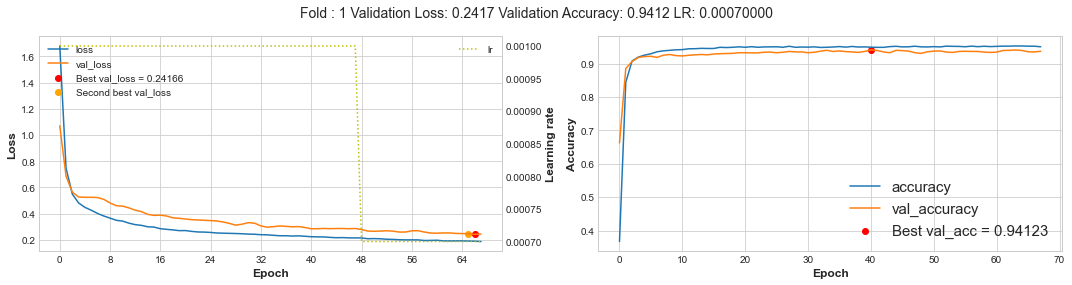

In [30]:
%%time
build_models(models=models_1_2)
historys_1_2 = fold_models(models=models_1_2, X=X_train_1_2,
                           y=y_train_1_2)
evaluate_models(models=models_1_2, historys=historys_1_2,
                X_test=X_test_1_2, y_test=y_test_1_2)


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 9)]          0           []                               
                                                                                                  
 dense_12 (Dense)               (None, 128)          1280        ['input[0][0]']                  
                                                                                                  
 batch_normalization_12 (BatchN  (None, 128)         512         ['dense_12[0][0]']               
 ormalization)                                                                                    
                                                                                                  
 dense_13 (Dense)               (None, 64)           8256        ['batch_normalization_12[0]

C:\Users\furyx\AppData\Local\Temp/ipykernel_3988/1664447733.py:47: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b = True, linestyle = '-')


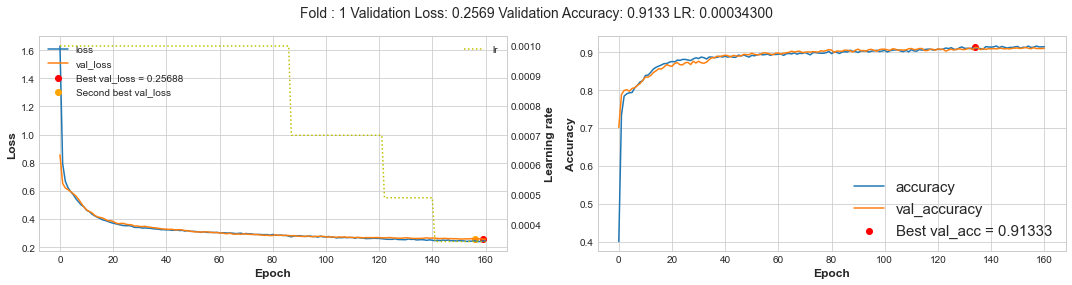

In [31]:
%%time
build_models(models=models_3_4_6_7)
historys_3_4_6_7 = fold_models(models=models_3_4_6_7, X=X_train_3_4_6_7,
                              y=y_train_3_4_6_7)
evaluate_models(models=models_3_4_6_7, historys=historys_3_4_6_7,
                X_test=X_test_3_4_6_7, y_test=y_test_3_4_6_7)


Model: "mlp"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_block (DenseBlock)    multiple                  1792      
                                                                 
 dense_block_1 (DenseBlock)  multiple                  34048     
                                                                 
 dense_block_2 (DenseBlock)  multiple                  33408     
                                                                 
 dense_block_3 (DenseBlock)  multiple                  8512      
                                                                 
 output (Dense)              multiple                  390       
                                                                 
Total params: 78,150
Trainable params: 76,998
Non-trainable params: 1,152
_________________________________________________________________
Accuracy: 81.83
Model: "model"
________________________

C:\Users\furyx\AppData\Local\Temp/ipykernel_3988/1664447733.py:47: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b = True, linestyle = '-')


Accuracy: 83.52
Model: "cross_net"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_block_4 (DenseBlock)  multiple                  1792      
                                                                 
 dense_block_5 (DenseBlock)  multiple                  34048     
                                                                 
 dense_block_6 (DenseBlock)  multiple                  33408     
                                                                 
 dense_block_7 (DenseBlock)  multiple                  8512      
                                                                 
 dense_20 (Dense)            multiple                  90        
                                                                 
 concatenate_3 (Concatenate)  multiple                 0         
                                                                 
 batch_normalization_20 (Bat  multiple   

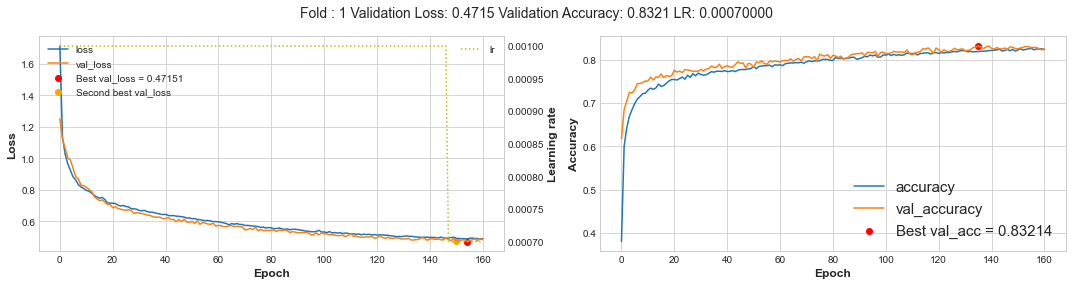

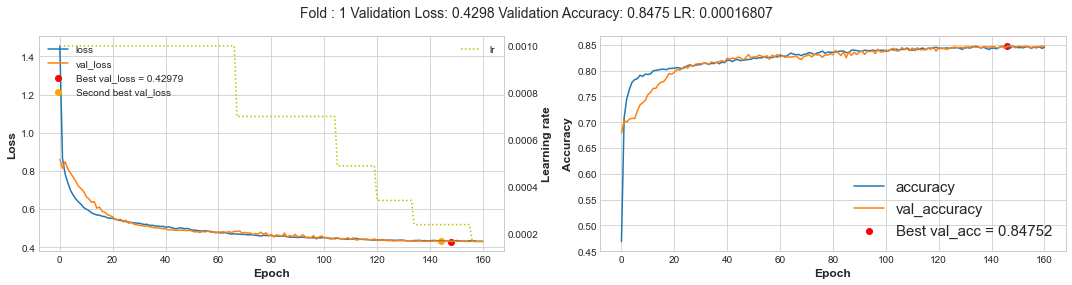

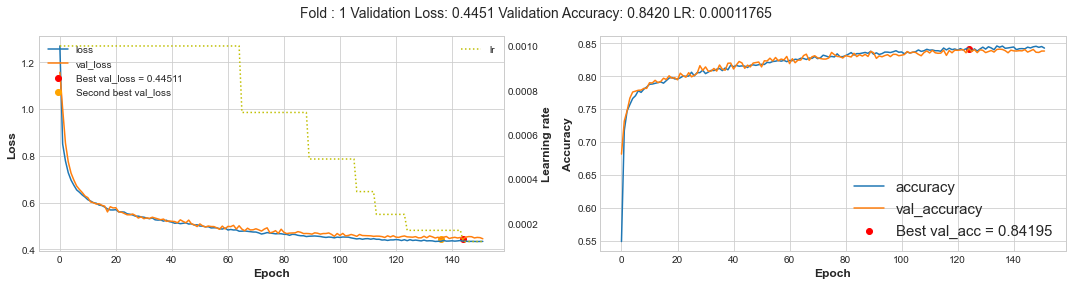

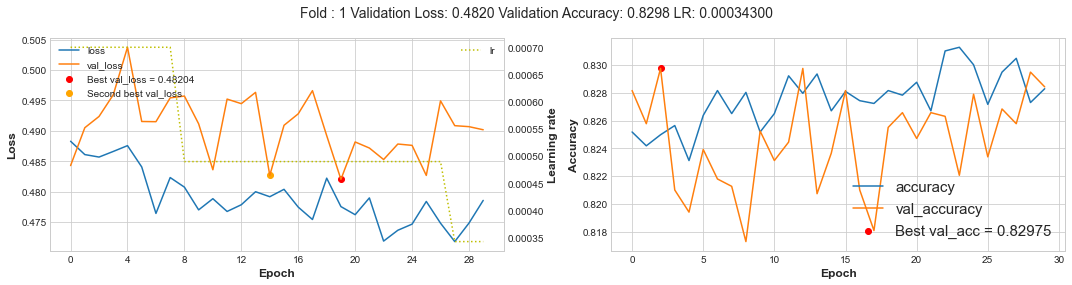

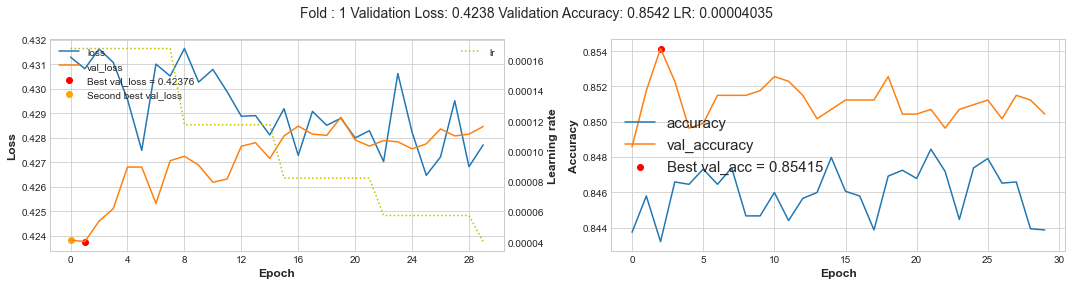

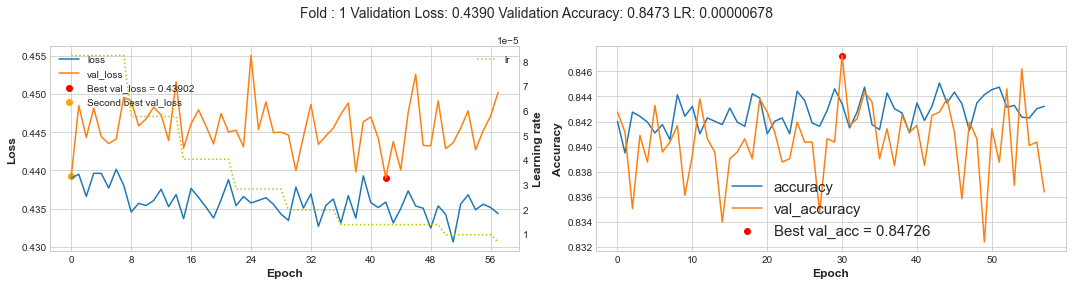

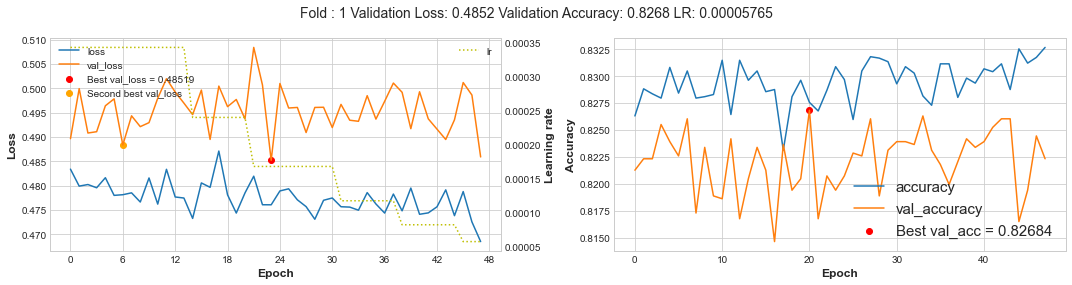

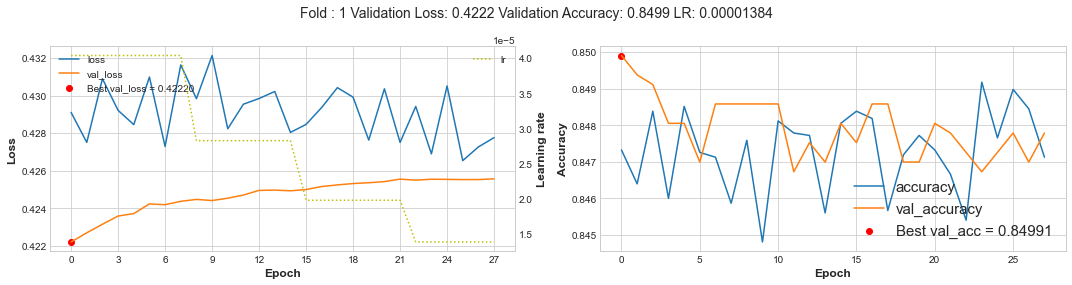

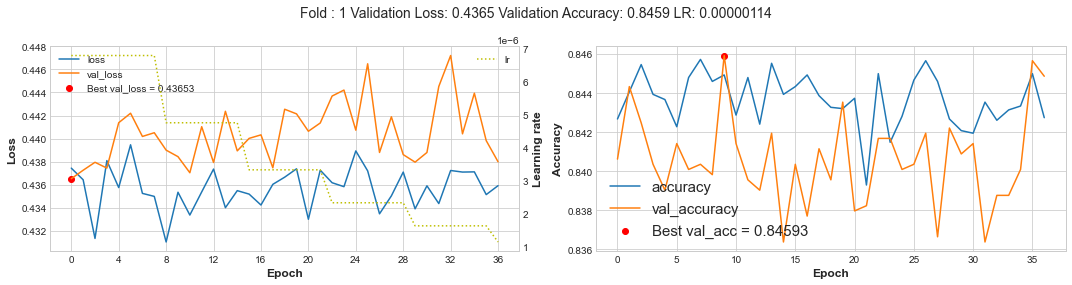

In [32]:
%%time
build_models(models=models)
historys = fold_models(models=models, X=X_train,
                      y=y_train)
evaluate_models(models=models, historys=historys,
                X_test=X_test, y_test=y_test)


In [33]:
preds_test = np.zeros((1, 1))
preds_test_1_2 = np.zeros((1, 1))
preds_test_3_4_6_7 = np.zeros((1, 1))

In [34]:
preds_test = predict_models(models = models, X_test = X_test)
preds_test_1_2 = predict_models(models = models_1_2, X_test = X_test)
preds_test_3_4_6_7 = predict_models(models = models_3_4_6_7, X_test = X_test)

In [35]:
results = np.argmax(preds_test, axis=1)
results_1_2 = np.argmax(preds_test_1_2, axis=1)
results_3_4_6_7 = np.argmax(preds_test_3_4_6_7, axis=1)
preds_test_1_2_3_4_6_7 = preds_test_1_2 + preds_test_3_4_6_7
results_1_2_3_4_6_7 = np.argmax(preds_test_1_2_3_4_6_7, axis=1)
preds_test_all = preds_test + preds_test_1_2 + preds_test_3_4_6_7
results_preds_test_all = np.argmax(preds_test_all, axis=1)

## results

In [36]:
accuracy_score(y_test, results)

0.837575564747057

In [37]:
accuracy_score(y_test, results_1_2)

0.5165447025135221

In [38]:
accuracy_score(y_test, results_3_4_6_7)

0.41329939548202355

## results_preds_test_all

In [39]:
accuracy_score(y_test, results_preds_test_all)

0.8378937321030863

## results_1_2_3_4_6_7

In [40]:
accuracy_score(y_test, results_1_2_3_4_6_7)

0.6492204899777283

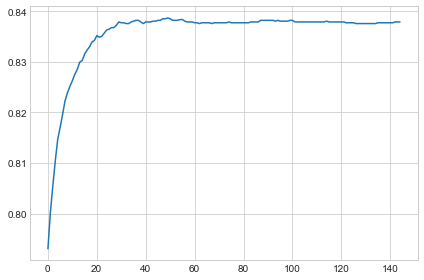

In [41]:
scores = []
# float step
for WEIGHT in np.arange(0.1, 3., 0.02):
    results_bag = []
    preds_hat = preds_test.copy()
    for e, val in enumerate(preds_hat):
        # print(f'{val}')
        val[0] += preds_test_1_2[e][0]/WEIGHT
        val[1] += preds_test_1_2[e][1]/WEIGHT
        for i in range(2, NUM_CLASSES):
            val[i] += preds_test_3_4_6_7[e][i]/WEIGHT

        results_bag.append(np.argmax(val, axis=0))

    scores.append(accuracy_score(y_test, results_bag))

# for i, score in enumerate(scores):
#     print(f'{i}, {score}')

plt.plot(scores)


In [42]:
max(scores)

0.8386891504931594

In [43]:
_, counts = np.unique(y_test, return_counts=True)

In [44]:
total_counts = sum(counts)

In [45]:
weights = [total_counts/x for x in counts]

In [46]:
from numpy.linalg import norm
# normalize a vector to have unit norm
def normalize(weights):
	# calculate l1 vector norm
	result = norm(weights, 1)
	# check for a vector of all zeros
	if result == 0.0:
		return weights
	# return normalized vector (unit norm)
	return weights / result

print(weights)
w2 = normalize(weights)
print(w2)

[3.931207004377736, 3.3960021609940574, 9.961965134706814, 10.009554140127388, 10.009554140127388, 6.623814541622761]
[0.08948371 0.07730116 0.22675824 0.22784148 0.22784148 0.15077392]


In [47]:
norm(counts, 1)

6286.0

## results__1_2_3_4_6_7w weighted

In [48]:
results__1_2_3_4_6_7w = []
preds_hat = preds_test.copy()
for e, val in enumerate(preds_hat):
    # print(f'{val}')
    val[0] += preds_test_1_2[e][0]/weights[0]
    val[1] += preds_test_1_2[e][1]/weights[1]
    for i in range(2, NUM_CLASSES):
        val[i] += preds_test_3_4_6_7[e][i]/weights[i]
        
    results__1_2_3_4_6_7w.append(np.argmax(val, axis=0))

accuracy_score(y_test, results__1_2_3_4_6_7w)

0.8369392300349984

In [49]:
w2

array([0.08948371, 0.07730116, 0.22675824, 0.22784148, 0.22784148,
       0.15077392])

## results__1_2_3_4_6_7b

In [50]:
results__1_2_3_4_6_7b = []
preds_hat = preds_test_1_2.copy()
for e, val in enumerate(preds_hat):
    # print(f'{val}')
    val[0] = preds_test_1_2[e][0]
    val[1] = preds_test_1_2[e][1]
    for i in range(2, NUM_CLASSES):
        val[i] = preds_test_3_4_6_7[e][i]
        
    results__1_2_3_4_6_7b.append(np.argmax(val, axis=0))
accuracy_score(y_test, results__1_2_3_4_6_7b)

0.6531975819280942

In [51]:
blend = np.array([results,
                  # results_1_2,
                  # results_3_4_6_7,
                  # results_1_2_3_4_6_7,
                  results_preds_test_all,
                  results__1_2_3_4_6_7w,
                #   results__1_2_3_4_6_7b
                  ])


In [52]:
blend.shape

(3, 6286)

In [53]:
ensemble = stats.mode(np.array(blend), axis=0)[0]

In [54]:
accuracy_score(y_test, ensemble[0])

0.837575564747057

In [55]:
ensemble.shape

(1, 6286)

In [56]:
ensemble[0].shape

(6286,)

In [90]:
(np.ones((1, 1))+np.zeros((1, 8)))+np.ones((1, 1))+np.ones((1, 8))

array([[3., 3., 3., 3., 3., 3., 3., 3.]])